# 0. LIBRARIES IMPORT


In [ ]:
!pip install bt
!pip install yfinance

In [1]:
# python utility libraries
import os as os
import datetime as dt
import itertools as it

# data processing libraries
import pandas as pd
import numpy as np

# signals backtesting library
import bt as bt

# fetching data
import yfinance as yf

# pandas financial data reader library
import pandas_datareader as dr
yf.pdr_override()

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# handling warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# general parameters
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

%matplotlib inline

Create a dataset sub-folder that we will use to store the financial data downloaded

In [3]:
if not os.path.exists('./datasets'): os.makedirs('./datasets')

# 1. DATA PROCESSING

## a. data acquisition

We will aquire historic daily stock market data of the "International Business Machines" (IBM) corporation (ticker symbol: "IBM").

In [4]:
# set to start and end date of the data download
start_date = dt.datetime(1990, 12, 31)
end_date = dt.datetime(2017, 12, 31)

# download ibm market data
ibm_data = yf.download('IBM', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
print(f"dataset shape: {ibm_data.shape}")

print("\nHere is a sample:")

ibm_data.head()

dataset shape: (6804, 6)

Here is a sample:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-12-31,27.097275,27.127151,26.977772,27.007648,12.125886,1930079
1991-01-02,26.977772,27.186901,26.798517,26.798517,12.031997,4341737
1991-01-03,26.858271,27.216778,26.828394,26.888145,12.072230,5470162
1991-01-04,26.947897,27.007648,26.738768,26.798517,12.031997,4540058
1991-01-07,26.619265,26.738768,26.290630,26.350382,11.830790,4976450


## b. preprocessing

Let's inspect the adjusted closing price of the downloaded IBM data:

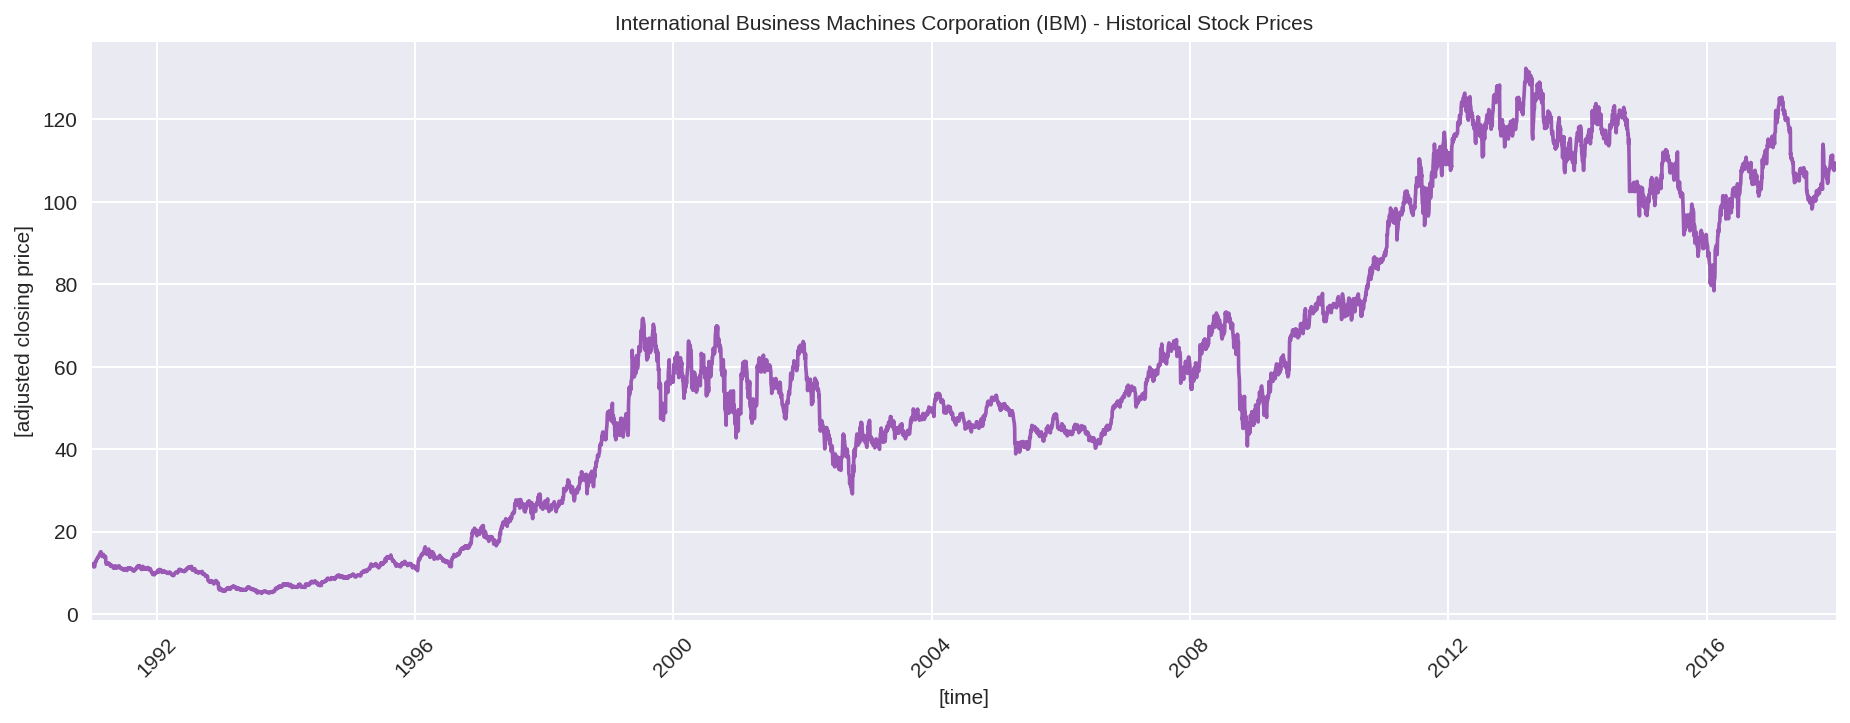

In [6]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot ibm stock daily adjusted closing prices
ax.plot(ibm_data.index, ibm_data['Adj Close'], color='#9b59b6')

# rotate x-ticks
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[adjusted closing price]', fontsize=10)

# set plot title
plt.title('International Business Machines Corporation (IBM) - Historical Stock Prices', fontsize=10);

In [7]:
# save the IBM downloaded dataset
ibm_data.to_csv('./datasets/ibm_data_1990_2017_daily.csv', sep=';', encoding='utf-8')

## c. data analysis

Here, we implement the **Moving Average Crossover** trading strategy. In general, **crossover trading** refers to the idea that changes of market situations can be determined based on price “breakouts”. A crossover can be interpreted as another measure of a financial instruments momentum. In the past crossover signals have been extensively used to determine that it’s time to either buy or sell the underlying asset.

The price crossover signals of a simple **Moving Average Crossover** trading strategy are triggered by the following events:

>- Generate a **short** trading signal once the price of a financial instrument drops below the general price trend, e.g., 100-days moving average band.
>- Generate a **long** trading signal once the price of a financial instrument exceeds the general price trend, e.g., 100-days moving average band.

An enhancement of the **Moving Average Crossover** is to apply two moving averages to a chart: one long running moving average (e.g., a 200-days SMAV) and one short running moving average (e.g., 20-days SMAV). Once the short running moving average crosses above the long running moving average a **Buy** or **Long** signal is triggered, as it indicates that the trend is shifting up (this is known as a "golden cross"). On the other hand, when the short running moving average crosses below the long running moving average, a **Sell** or **Short** signal is triggered, as it indicates that the trend is shifting down (his is known as a "dead/death cross")

Let's start implementing this enhanced trading strategy by setting the distinct moving average window sizes that specify the number of historical daily adjusted closing prices of the IBM stock to be considered in the calculation of the rolling moving average:

In [8]:
cross_mav_days_15 = 15  # set "fast" short-running moving average indicator lookback, days = 15
cross_mav_days_60 = 60  # set "slow" short-running moving average indicator lookback, days = 60
cross_mav_days_200 = 200  # set "trend" long-running moving average indicator lookback, days = 200

Calculate the rolling moving averages of window sizes: 15 days, 60 days and 200 days. In general the **"Simple Moving Average (SMAV)"** of a financial instrument $i$ (e.g., a stock, commodity, fx-rate) is defined as the mean of the previous $n$ prices, formally denoted by:

$$SMA_{i}(t)=\frac{1}{n} \sum_{k=0}^{n-1} p_{i}(t-k)$$


were $t$ denotes the current point in time and $n$ the lookback.

We can calculate the SMAV by just using the Pandas `rolling()` and `mean()`function:


In [9]:
cross_mav_15 = pd.Series(ibm_data['Adj Close'].rolling(window = cross_mav_days_15).mean(), name = 'SMAV_15')
cross_mav_60 = pd.Series(ibm_data['Adj Close'].rolling(window = cross_mav_days_60).mean(), name = 'SMAV_60')
cross_mav_200 = pd.Series(ibm_data['Adj Close'].rolling(window = cross_mav_days_200).mean(), name = 'SMAV_200')

In [10]:
# merging the rolling moving average values with the original market data
cross_mav_ibm_data = ibm_data.join(cross_mav_15)
cross_mav_ibm_data = cross_mav_ibm_data.join(cross_mav_60)
cross_mav_ibm_data = cross_mav_ibm_data.join(cross_mav_200)

In [11]:
cross_mav_ibm_data[['Adj Close', 'SMAV_15', 'SMAV_60', 'SMAV_200']].iloc[200:210]

,Adj Close,SMAV_15,SMAV_60,SMAV_200
Date,,,,
1991-10-15,11.566664,11.213472,11.078775,11.863328
1991-10-16,11.275420,11.188508,11.082854,11.859545
1991-10-17,11.081254,11.151524,11.083468,11.854590
1991-10-18,11.136730,11.137655,11.085463,11.850114
1991-10-21,11.122855,11.112691,11.087227,11.846574
1991-10-22,10.928693,11.082179,11.084156,11.842734
1991-10-23,10.928693,11.062762,11.080629,11.840035
1991-10-24,10.900955,11.057214,11.077324,11.836392
1991-10-25,10.873219,11.055365,11.073557,11.832744


Now, let's plot the historical daily adjusted closing prices of the IBM stock (blue) as well as its 15 days (green), 60 days (red) as well as 200 days (yellow) rolling moving averages:

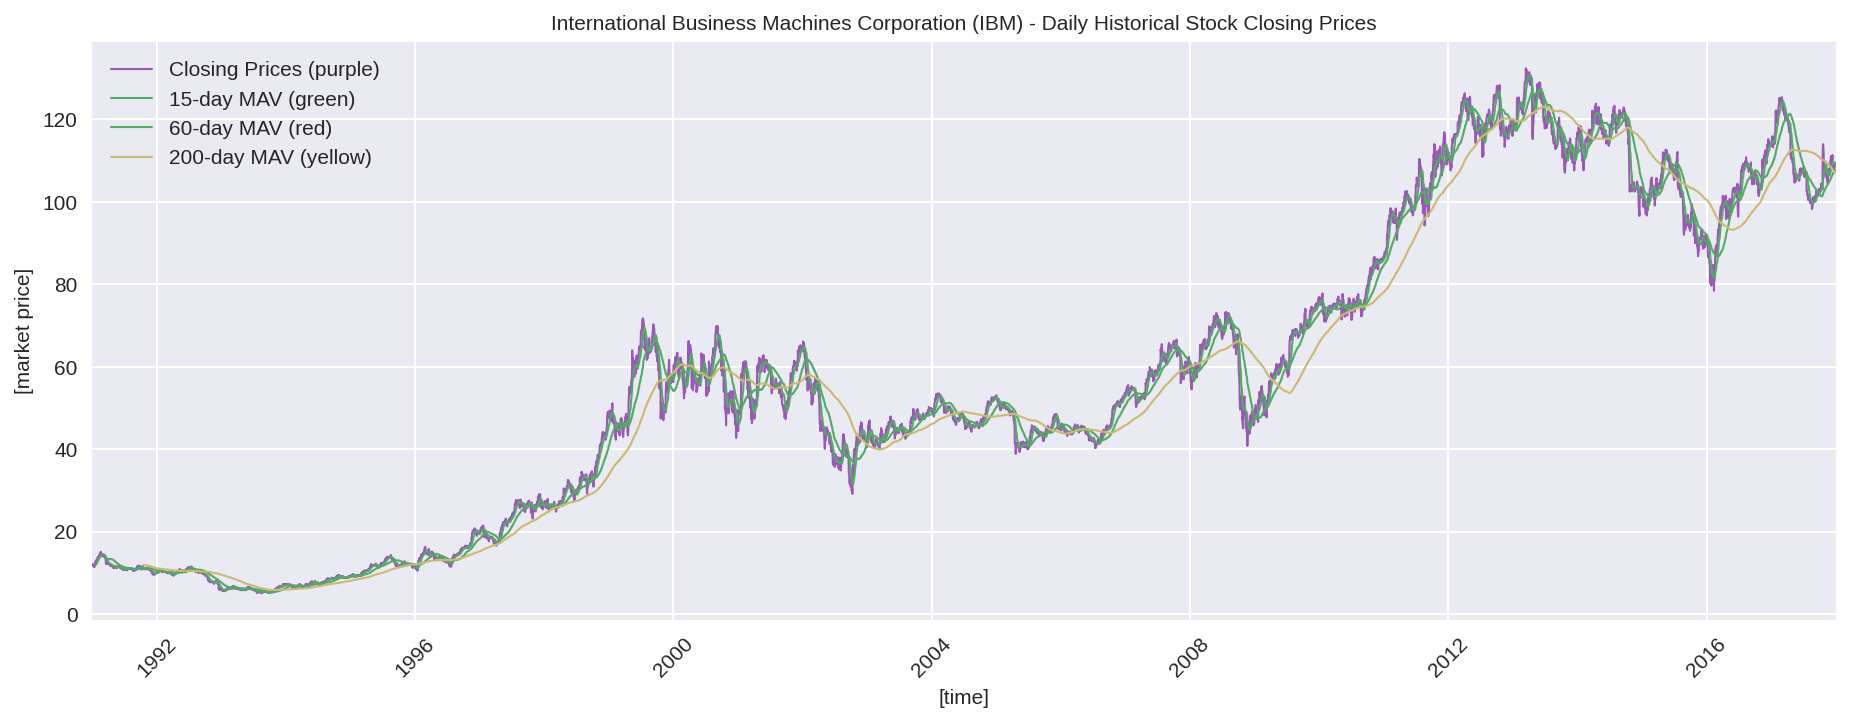

In [12]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot adjusted closing prices and moving averages
ax.plot(cross_mav_ibm_data['Adj Close'], lw=1.0, color='#9b59b6', label='Closing Prices (purple)')
ax.plot(cross_mav_ibm_data['SMAV_15'], color='C1',lw=1.0, label='15-day MAV (green)')
ax.plot(cross_mav_ibm_data['SMAV_60'], color='C1',lw=1.0, label='60-day MAV (red)')
ax.plot(cross_mav_ibm_data['SMAV_200'], color='C4', lw=1.0, label='200-day MAV (yellow)')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[market price]', fontsize=10)

# set plot legend
plt.legend(loc="upper left", numpoints=1, fancybox=True)

# set plot title
plt.title('International Business Machines Corporation (IBM) - Daily Historical Stock Closing Prices', fontsize=10);

# SIGNAL GENERATION

Here, the aim is to derive trading signals from of two distinct moving average crossover trading strategy configurations. We will generate a **long-signal** (+1.0) for the time intervals where the fast moving averages are above the 200-day moving average. In addition we generate a **short-signal** (-1.0) for the time intervals where the fast moving averages are below the 200-day moving average:

In [13]:
# create 'fast' trend-following signals
cross_mav_ibm_data['SIGNAL_15'] = 0.0
cross_mav_ibm_data.loc[cross_mav_ibm_data['SMAV_15'] > cross_mav_ibm_data['SMAV_200'], 'SIGNAL_15'] = 1.0
cross_mav_ibm_data.loc[cross_mav_ibm_data['SMAV_15'] < cross_mav_ibm_data['SMAV_200'], 'SIGNAL_15'] = -1.0

# create 'slow' trend-following signals
cross_mav_ibm_data['SIGNAL_60'] = 0.0
cross_mav_ibm_data.loc[cross_mav_ibm_data['SMAV_60'] > cross_mav_ibm_data['SMAV_200'], 'SIGNAL_60'] = 1.0
cross_mav_ibm_data.loc[cross_mav_ibm_data['SMAV_60'] < cross_mav_ibm_data['SMAV_200'], 'SIGNAL_60'] = -1.0

In addition, let's also prepare a backtest of a **"baseline"** in terms of a simple **buy-and-hold** trading strategy for comparison purposes. Our buy-and-hold strategy sends a "long" (+1.0) signal for each time step:

In [14]:
cross_mav_ibm_data['SIGNAL_BASE'] = 1.0

Now, we prepare the trading signal data to be utilized in  backtesting the long-/short-term moving-average trading strategy:

In [15]:
# convert signals to Pandas DataFrame
cross_mav_ibm_signal_data = pd.DataFrame(cross_mav_ibm_data[['SIGNAL_15', 'SIGNAL_60', 'SIGNAL_BASE']], columns=['SIGNAL_15', 'SIGNAL_60', 'SIGNAL_BASE'])

# convert pandas DataFrame index to datatype: datetime
cross_mav_ibm_signal_data = cross_mav_ibm_signal_data.set_index(pd.to_datetime(ibm_data.index))

some of the exemplary signal deviations between the 15-days and 60-days crossover moving average trading strategies:

In [16]:
cross_mav_ibm_signal_data[cross_mav_ibm_signal_data['SIGNAL_15'] != cross_mav_ibm_signal_data['SIGNAL_60']].head(10)

,SIGNAL_15,SIGNAL_60,SIGNAL_BASE
Date,,,
1992-05-15,1.0,-1.0,1.0
1992-05-18,1.0,-1.0,1.0
1992-05-19,1.0,-1.0,1.0
1992-05-20,1.0,-1.0,1.0
1992-05-21,1.0,-1.0,1.0
1992-05-22,1.0,-1.0,1.0
1992-05-26,1.0,-1.0,1.0
1992-05-27,1.0,-1.0,1.0
1992-05-28,1.0,-1.0,1.0


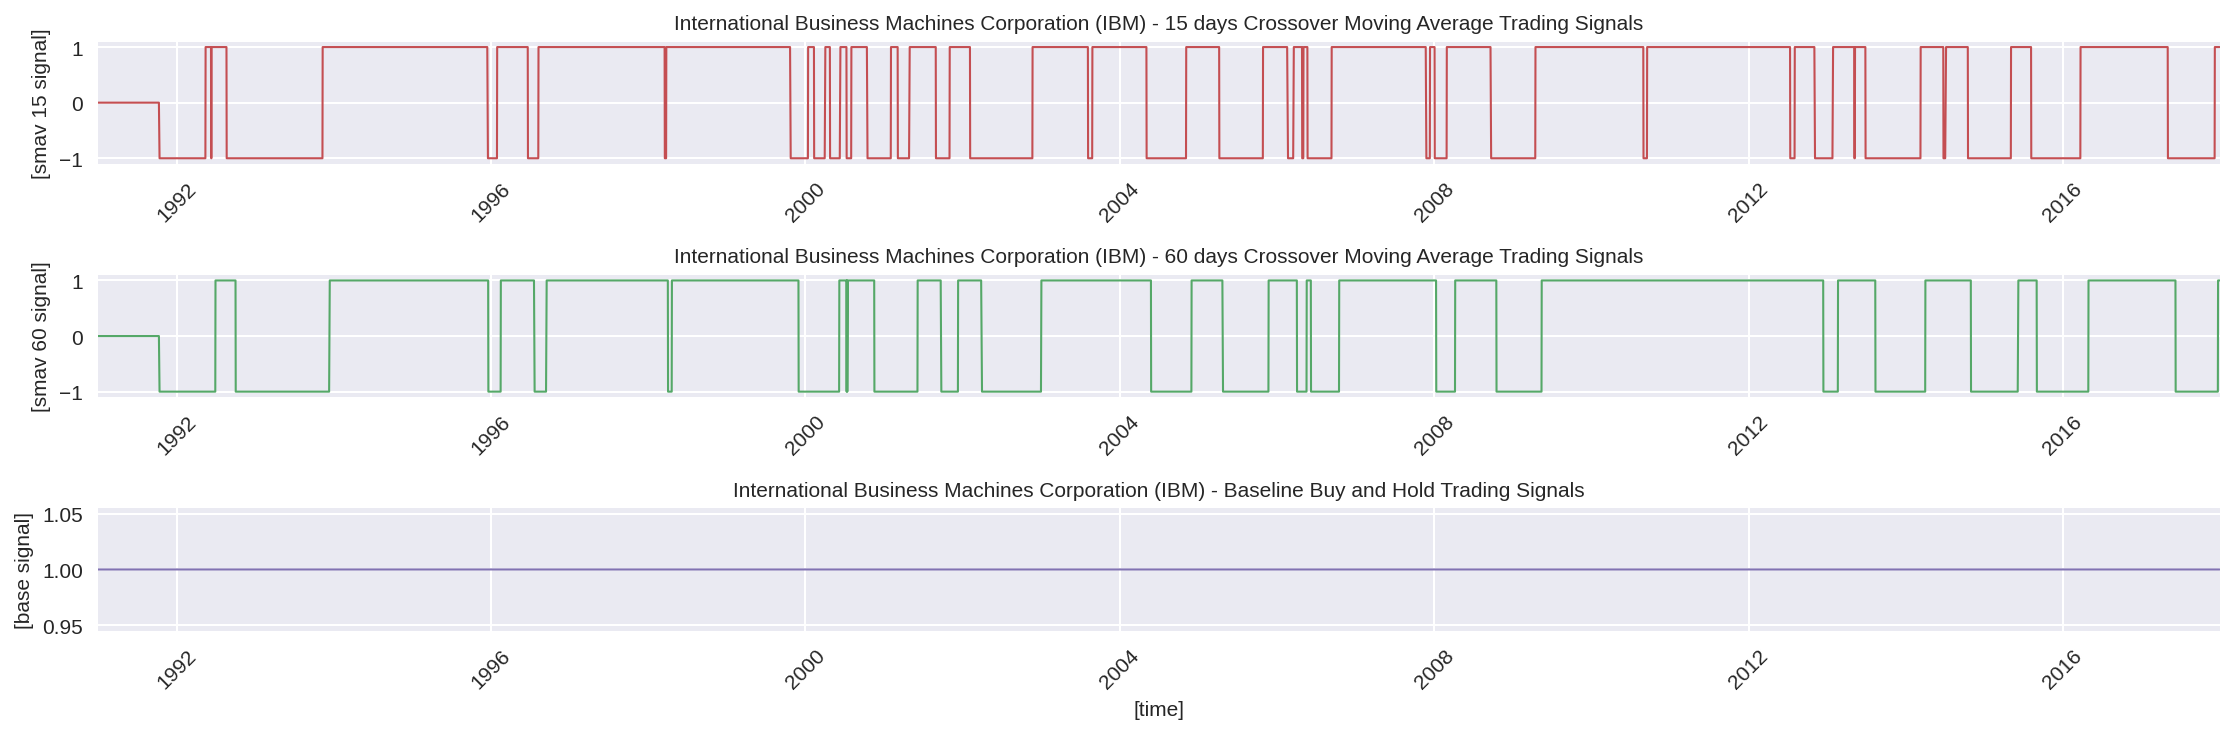

In [17]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(ncols=1, nrows=3)

ax[0].plot(cross_mav_ibm_signal_data['SIGNAL_15'], lw=1.0, color='C2', label='SMAV 16 (red)')
ax[1].plot(cross_mav_ibm_signal_data['SIGNAL_60'], lw=1.0, color='C1', label='SMAV 60 (green)')
ax[2].plot(cross_mav_ibm_signal_data['SIGNAL_BASE'], lw=1.0, color='C3', label='BASE (purple)')

# set axis labels
plt.xlabel('[time]', fontsize=10)
ax[0].set_xlim([start_date, end_date])
ax[0].set_ylabel('[smav 15 signal]', fontsize=10)
ax[1].set_xlim([start_date, end_date])
ax[1].set_ylabel('[smav 60 signal]', fontsize=10)
ax[2].set_xlim([start_date, end_date])
ax[2].set_ylabel('[base signal]', fontsize=10)

# rotate the x-axis labels
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)

for tick in ax[2].get_xticklabels():
    tick.set_rotation(45)

# set plot title
ax[0].set_title('International Business Machines Corporation (IBM) - 15 days Crossover Moving Average Trading Signals', fontsize=10)
ax[1].set_title('International Business Machines Corporation (IBM) - 60 days Crossover Moving Average Trading Signals', fontsize=10)
ax[2].set_title('International Business Machines Corporation (IBM) - Baseline Buy and Hold Trading Signals', fontsize=10)

# reset plot layout
plt.tight_layout()

Let's determine the total number of **long-short signal changes** of the distinct trading strategies:

In [18]:
# signal changes of the 15-200 days moving average crossover trading strategy
len(list(it.groupby(cross_mav_ibm_signal_data['SIGNAL_15'], lambda x: x > 0)))

64

In [19]:
# signal changes of the 60-200 days moving average crossover trading strategy
len(list(it.groupby(cross_mav_ibm_signal_data['SIGNAL_60'], lambda x: x > 0)))

44

In [20]:
# signal changes of the baseline buy and hold trading strategy
len(list(it.groupby(cross_mav_ibm_signal_data['SIGNAL_BASE'], lambda x: x > 0)))

1

# SIGNAL BACKTEST

First, let's prepare the market data to be utilized in backtesting the crossover moving average trading strategy configurations:

In [21]:
# extract the ibm stock closing prices
ibm_market_data = pd.DataFrame(ibm_data['Adj Close'], columns=['Adj Close'])

# rename the 'close' column to 'ibm' (since this is the column we want to allocate to in the backtest)
ibm_market_data = ibm_market_data.rename(columns={'Adj Close': 'IBM'})

# convert pandas DataFrame index to datatype: datetime
ibm_market_data = ibm_market_data.set_index(pd.to_datetime(ibm_data.index))

Implementing a simple Moving Average Trading Strategy by interfacing the Python `bt`'s Algo class:

In [23]:
class MovingAverageStrategy(bt.Algo):

    # inits the strategy
    def __init__(self, signals):

        # set class signals
        self.signals = signals

    # calss the trading strategy
    def __call__(self, target):

        # case: current timestep in signals
        if target.now in self.signals.index[1:]:

            # get actual signal
            signal = self.signals[target.now]

            # set target weights according to signal
            target.temp['weights'] = dict(IBM=signal)

        # return 'True' since we want to move on to the next timestep
        return True

Define the moving average trading strategy backtest algorithm stack.

**Note:** That in the Python `bt` library a trading strategy usually consists of a so-called **stack of algorithms**. For each timestep of our backtest timeframe, the `bt` library executes all algorithm of the stack in sequential order. Each moving average strategy we aim to design and backtest consists in total of three algorithms, briefly described in the following:

> 1. `bt.algos.SelectAll()`: Selects all available stocks for trading except stock prices that correspond to NaN or 0.00.  
> 2. `MovingAverageStrategy()`: Assigns the calculated signal in terms of a weight value to the IBM stock.
> 3. `bt.algos.Rebalance()`: Rebalances the available capital based on the weights assigned to each stock.


Define the long-/short-term moving average trading strategy backtest algorithm stack:

In [25]:
cross_mav_ibm_strategy_15 = bt.Strategy(name='smav_15', algos=[bt.algos.SelectAll(), MovingAverageStrategy(cross_mav_ibm_signal_data['SIGNAL_15']), bt.algos.Rebalance()])
cross_mav_ibm_strategy_60 = bt.Strategy(name='smav_60', algos=[bt.algos.SelectAll(), MovingAverageStrategy(cross_mav_ibm_signal_data['SIGNAL_60']), bt.algos.Rebalance()])
cross_mav_ibm_strategy_base = bt.Strategy(name='base', algos=[bt.algos.SelectAll(), MovingAverageStrategy(cross_mav_ibm_signal_data['SIGNAL_BASE']), bt.algos.Rebalance()])

Let's now define the trading ('fees') commissions used in each rebalancing time-step of a backtest. To achieve this, the `bt` library expects a callable function that expects the following two parameters as an input:

> - the 'quantity', denoted by `q`, of rebalanced assets at a backtest time-step;
> - the 'price', denoted by `p`, of rebalanced assets at a backtest time-step.

Let's implement such a callable function defining a trading fee of **1\% (0.01)** per quantity of rebalanced asset (or a flat fee of **USD 5.00** per trade):

In [49]:
# trading fees function
def trading_fees_function(q, p):

    # calcluate trading fees (rebalanced-quantity * trading-fee)
    fees = q * 0.001 # non-flat fee of 1% per quantity of rebalanced asset
    # fees = 5.00 # flat fee of USD 5.00 per trade

    # return the total trading fees
    return fees

Upon completion of defining the long-/sort-term moving average strategies let's now init the corresponding backtests using (1) both strategies as well as (2) the market data that we aim to evaluate during the backtest:

In [50]:
ibm_backtest_cross_mav_15 = bt.Backtest(strategy=cross_mav_ibm_strategy_15, data=ibm_market_data, name='ibm_backtest_smav_15', commissions=trading_fees_function, progress_bar=True)
ibm_backtest_cross_mav_60 = bt.Backtest(strategy=cross_mav_ibm_strategy_60, data=ibm_market_data, name='ibm_backtest_smav_60', commissions=trading_fees_function, progress_bar=True)
ibm_backtest_cross_mav_base = bt.Backtest(strategy=cross_mav_ibm_strategy_base, data=ibm_market_data, name='ibm_backtest_smav_base', commissions=trading_fees_function, progress_bar=True)

Now, let's run the backtest of both configurations of the crossover moving average strategy as well as the defined baseline:

In [51]:
backtest_results_ibm = bt.run(ibm_backtest_cross_mav_15, ibm_backtest_cross_mav_60, ibm_backtest_cross_mav_base)

ibm_backtest_smav_15
0% [############################# ] 100% | ETA: 00:00:00ibm_backtest_smav_60
0% [############################# ] 100% | ETA: 00:00:00ibm_backtest_smav_base
0% [############################# ] 100% | ETA: 00:00:00

Inspect the individual backtest results and performance measures:

In [52]:
backtest_results_ibm.display()

Stat                 ibm_backtest_smav_15    ibm_backtest_smav_60    ibm_backtest_smav_base
-------------------  ----------------------  ----------------------  ------------------------
Start                1990-12-30              1990-12-30              1990-12-30
End                  2017-12-29              2017-12-29              2017-12-29
Risk-free rate       0.00%                   0.00%                   0.00%

Total Return         35.43%                  -83.44%                 805.50%
Daily Sharpe         0.18                    -0.10                   0.43
Daily Sortino        0.28                    -0.16                   0.73
CAGR                 1.13%                   -6.44%                  8.50%
Max Drawdown         -86.02%                 -94.10%                 -66.83%
Calmar Ratio         0.01                    -0.07                   0.13

MTD                  0.13%                   1.47%                   -0.36%
3m                   -7.53%                  -6.30

Let's collect the detailed backtest performance per timestep of the "fast" **15-200 days** crossover moving average strategy:

In [53]:
backtest_sma_15_ibm_details = ibm_backtest_cross_mav_15.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_sma_15_ibm_details['Abs. EQUITY'] = ibm_backtest_cross_mav_15.strategy.values # equity per timestep
backtest_sma_15_ibm_details['CASH'] = ibm_backtest_cross_mav_15.strategy.cash # cash per timestep
backtest_sma_15_ibm_details['POSITIONS'] = ibm_backtest_cross_mav_15.strategy.positions # positions per timestep
backtest_sma_15_ibm_details['FEES'] = ibm_backtest_cross_mav_15.strategy.fees # trading fees per timestep

In [55]:
backtest_sma_15_ibm_details.head(-10)

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
1990-12-30,100.000000,1.000000e+06,1000000.000000,0.0,0.0
1990-12-31,100.000000,1.000000e+06,1000000.000000,0.0,0.0
1991-01-02,100.000000,1.000000e+06,1000000.000000,0.0,0.0
1991-01-03,100.000000,1.000000e+06,1000000.000000,0.0,0.0
1991-01-04,100.000000,1.000000e+06,1000000.000000,0.0,0.0
...,...,...,...,...,...
2017-12-08,136.657002,1.366570e+06,58.972326,12429.0,0.0
2017-12-11,137.186642,1.371866e+06,58.972326,12429.0,0.0
2017-12-12,138.360613,1.383606e+06,58.972326,12429.0,0.0
2017-12-13,135.862599,1.358626e+06,58.972326,12429.0,0.0


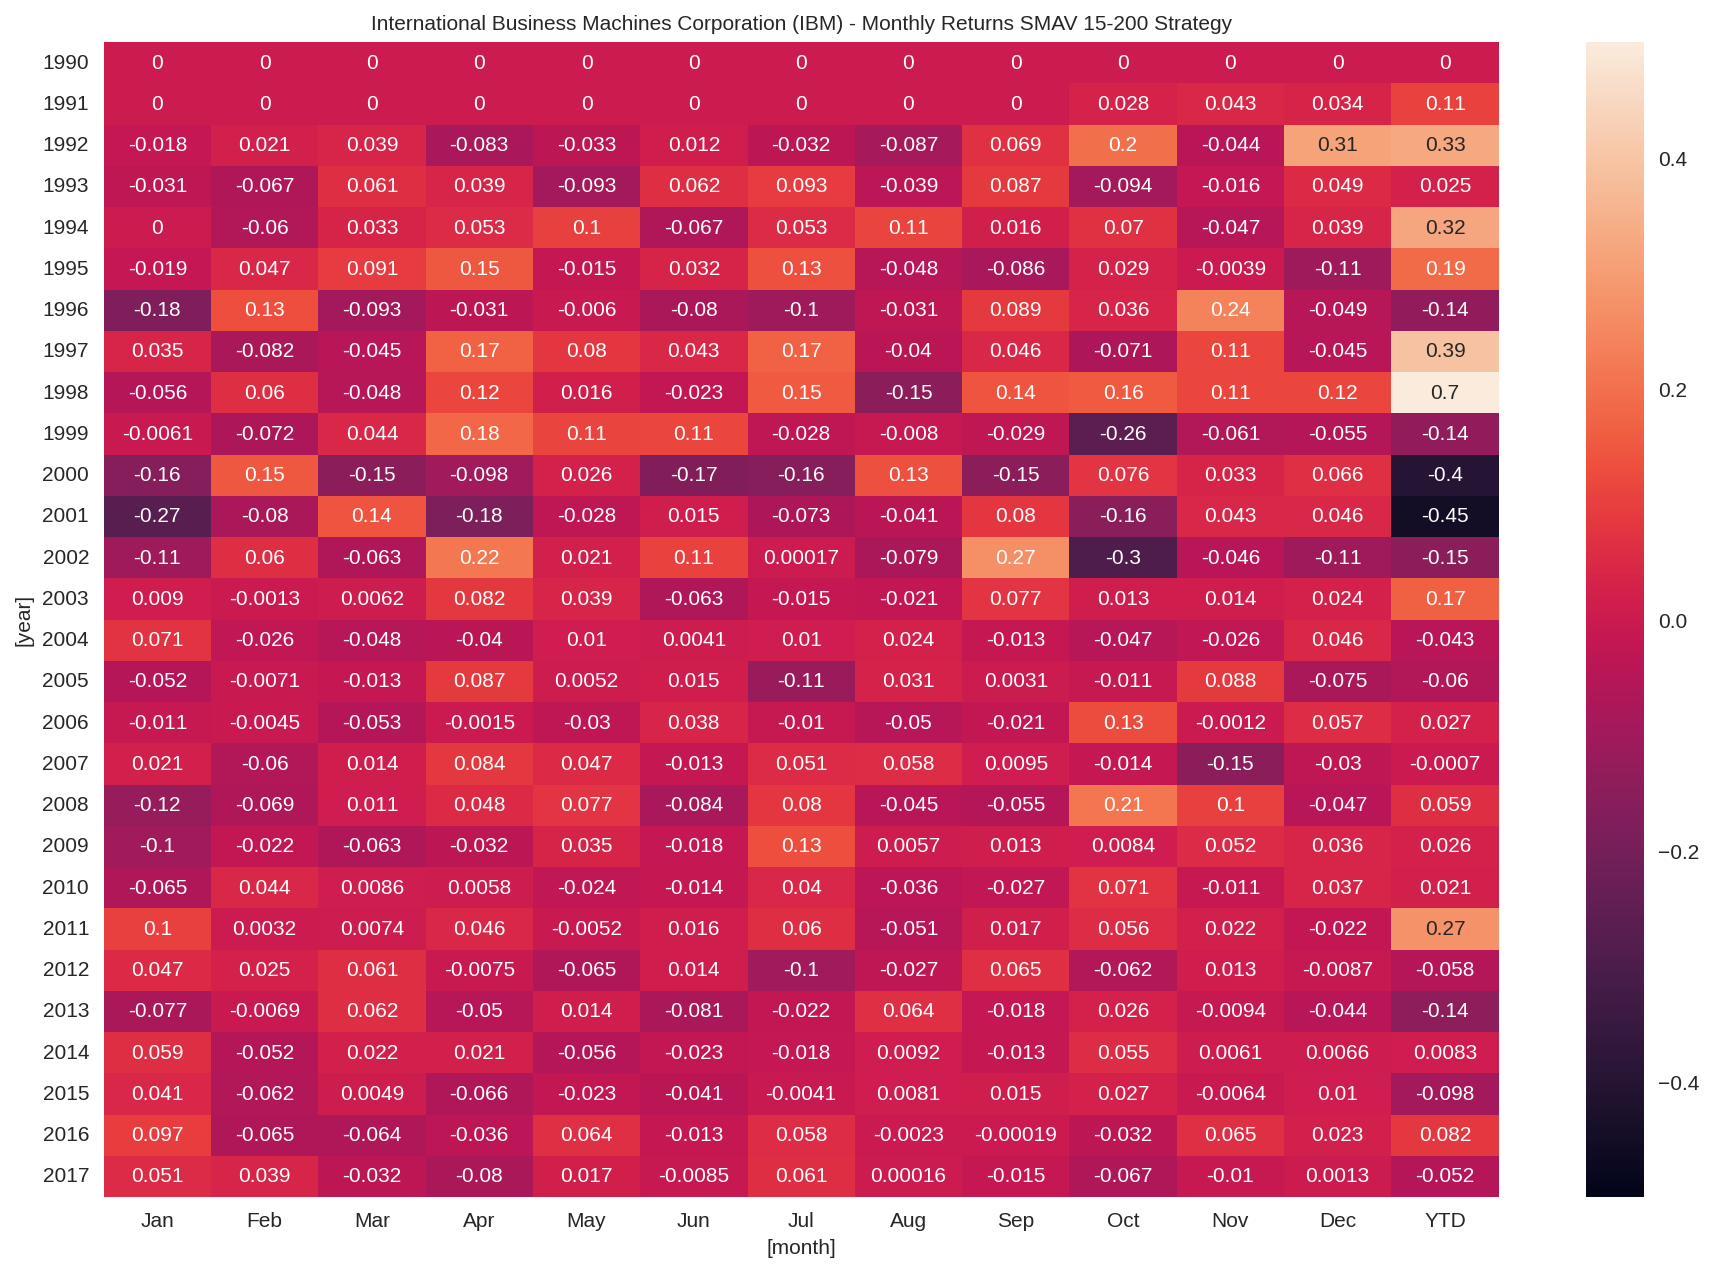

In [56]:
# monthly returns obtained by the 15-200 days crossover moving average strategy
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(ibm_backtest_cross_mav_15.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns SMAV 15-200 Strategy', fontsize=10);

We do the same for the "slow" **60-200 days** crossover moving average strategy:

In [57]:
backtest_sma_60_ibm_details = ibm_backtest_cross_mav_60.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_sma_60_ibm_details['Abs. EQUITY'] = ibm_backtest_cross_mav_60.strategy.values # equity per timestep
backtest_sma_60_ibm_details['CASH'] = ibm_backtest_cross_mav_60.strategy.cash # cash per timestep
backtest_sma_60_ibm_details['POSITIONS'] = ibm_backtest_cross_mav_60.strategy.positions # positions per timestep
backtest_sma_60_ibm_details['FEES'] = ibm_backtest_cross_mav_60.strategy.fees # fees per timestep

In [59]:
backtest_sma_60_ibm_details.head(-10)

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
1990-12-30,100.000000,1000000.000000,1000000.000000,0.0,0.000
1990-12-31,100.000000,1000000.000000,1000000.000000,0.0,0.000
1991-01-02,100.000000,1000000.000000,1000000.000000,0.0,0.000
1991-01-03,100.000000,1000000.000000,1000000.000000,0.0,0.000
1991-01-04,100.000000,1000000.000000,1000000.000000,0.0,0.000
...,...,...,...,...,...
2017-12-08,16.230190,162301.896872,324691.213584,-1477.0,0.024
2017-12-11,16.167249,161672.487610,323366.743515,-1465.0,0.012
2017-12-12,16.028871,160288.708681,320583.817323,-1440.0,0.025
2017-12-13,16.318291,163182.912071,326377.100037,-1493.0,-0.053


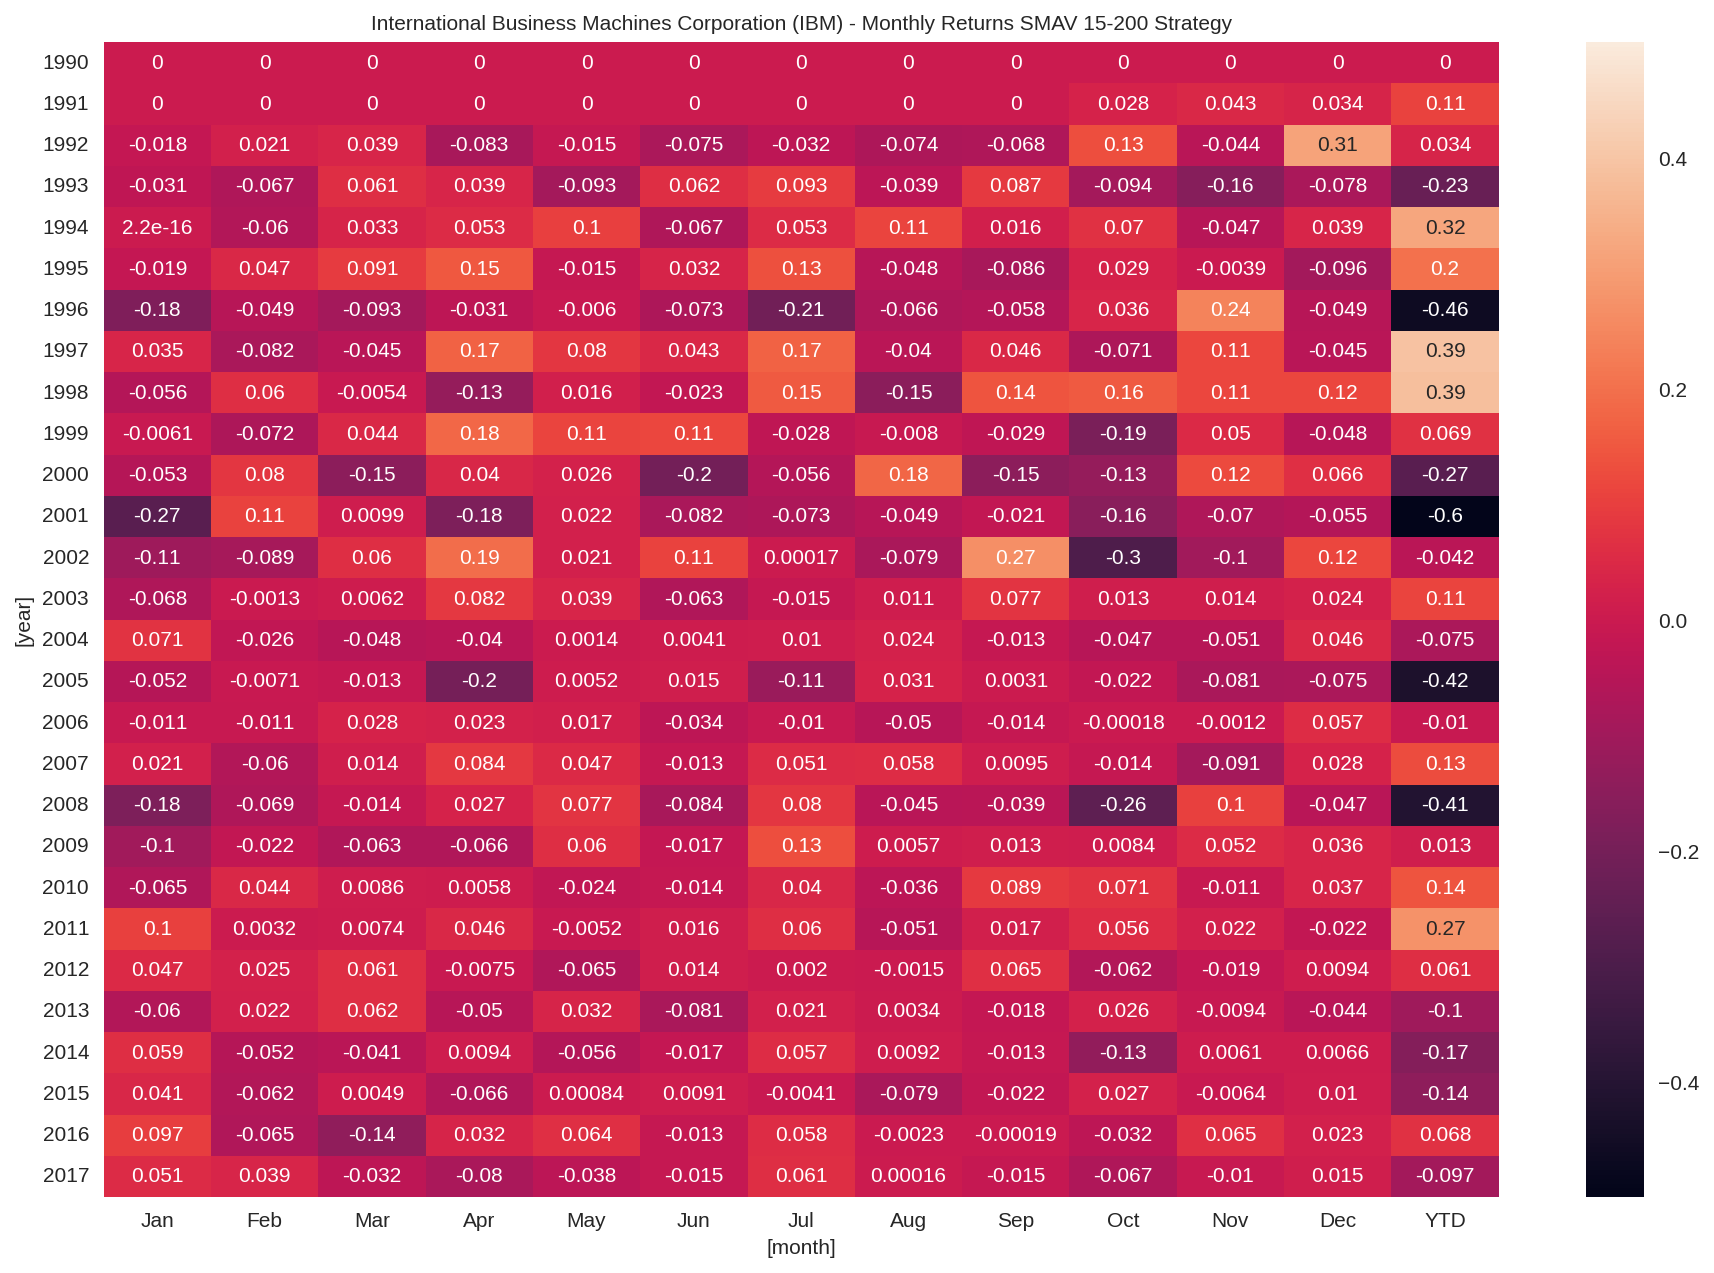

In [60]:
# monthly returns obtained by the 60-200 days crossover moving average strategy
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(ibm_backtest_cross_mav_60.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns SMAV 15-200 Strategy', fontsize=10);

Finally, we collect the detailed backtest performance per timestep of the "long only" baseline strategy:

In [61]:
backtest_sma_base_ibm_details = ibm_backtest_cross_mav_base.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_sma_base_ibm_details['Abs. EQUITY'] = ibm_backtest_cross_mav_base.strategy.values # equity per timestep
backtest_sma_base_ibm_details['CASH'] = ibm_backtest_cross_mav_base.strategy.cash # cash per timestep
backtest_sma_base_ibm_details['POSITIONS'] = ibm_backtest_cross_mav_base.strategy.positions # positions per timestep
backtest_sma_base_ibm_details['FEES'] = ibm_backtest_cross_mav_base.strategy.fees # fees per timestep

In [62]:
backtest_sma_base_ibm_details.head(-10)

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
1990-12-30,100.000000,1.000000e+06,1000000.000000,0.0,0.000
1990-12-31,100.000000,1.000000e+06,1000000.000000,0.0,0.000
1991-01-02,99.991690,9.999169e+05,9.840000,83104.0,83.104
1991-01-03,100.326047,1.003260e+06,9.840000,83104.0,0.000
1991-01-04,99.991690,9.999169e+05,9.840000,83104.0,0.000
...,...,...,...,...,...
2017-12-08,913.701054,9.137011e+06,0.276662,83105.0,0.000
2017-12-11,917.242426,9.172424e+06,0.276662,83105.0,0.000
2017-12-12,925.092042,9.250920e+06,0.276662,83105.0,0.000
2017-12-13,908.389377,9.083894e+06,0.276662,83105.0,0.000


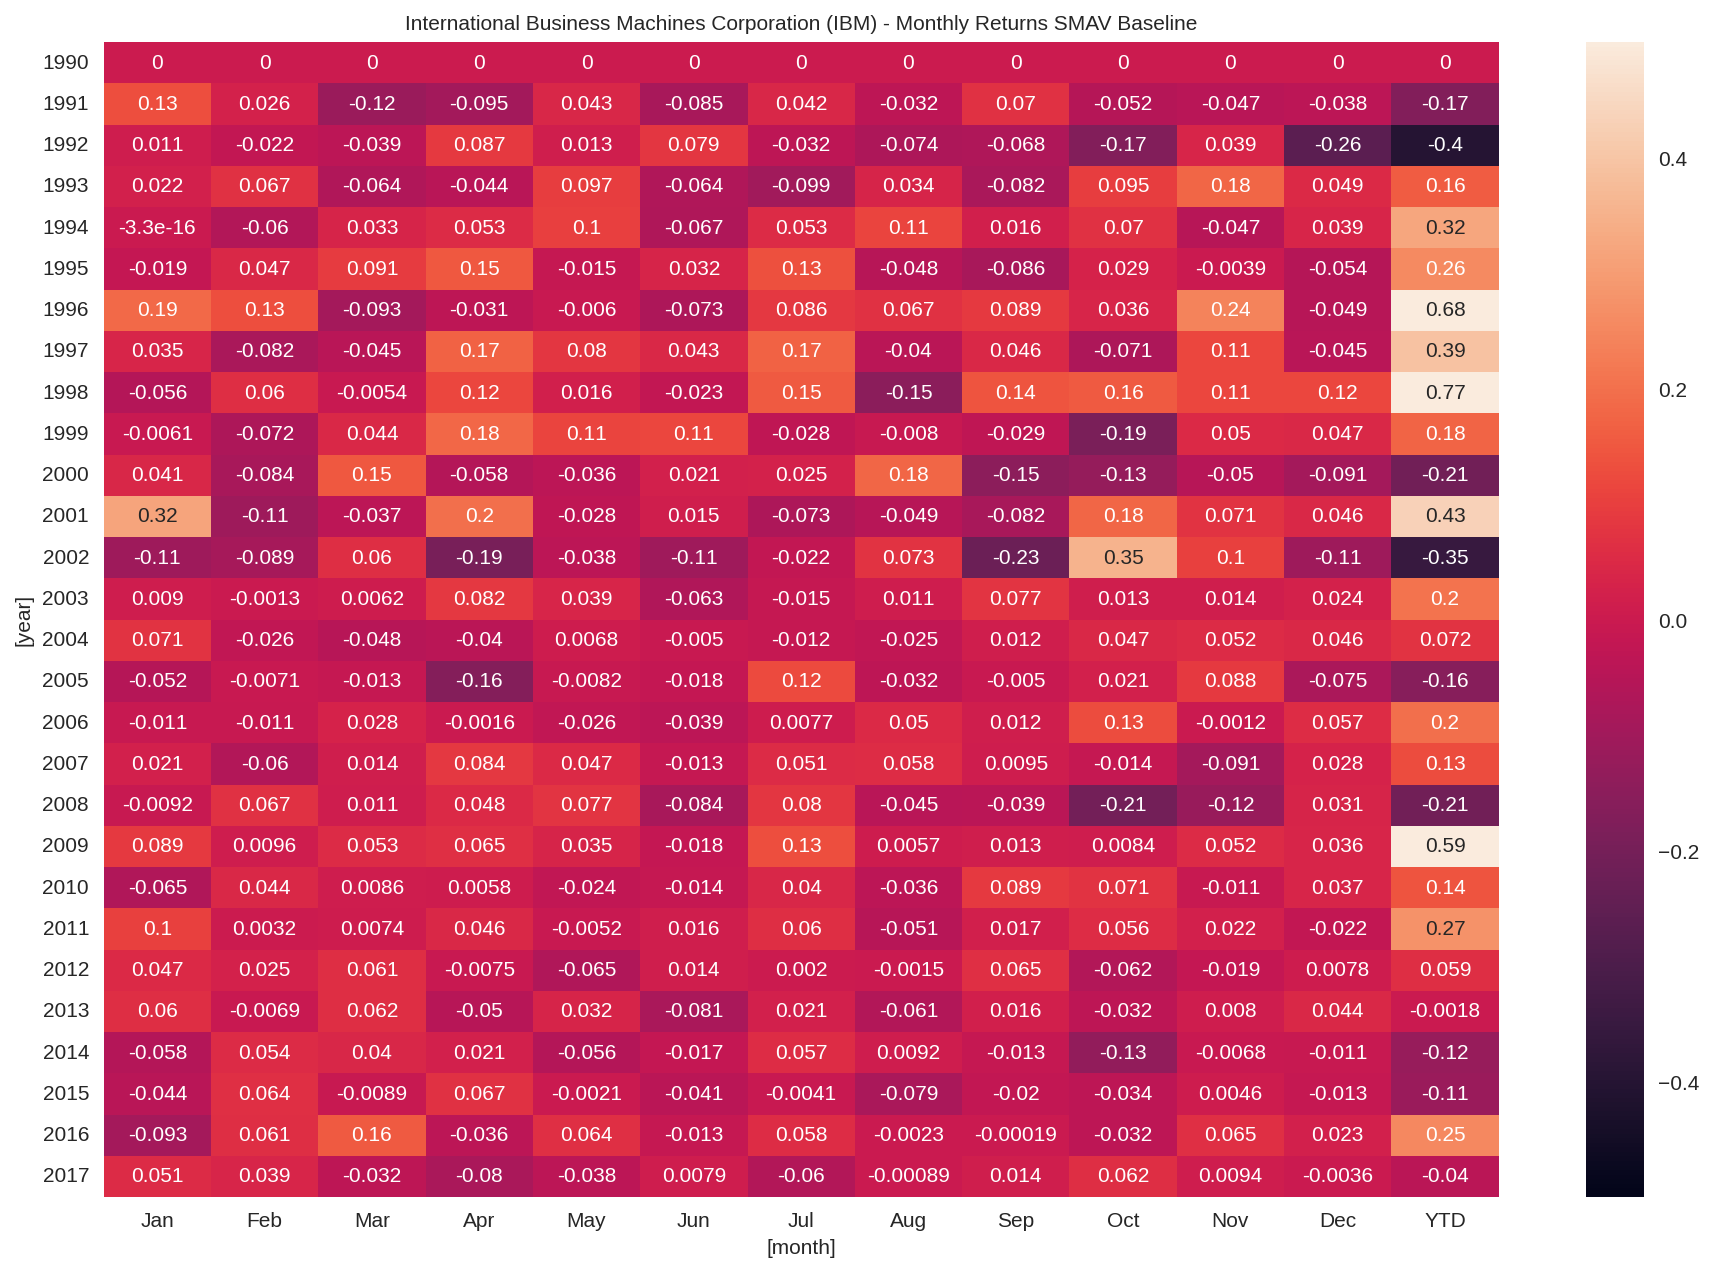

In [63]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(ibm_backtest_cross_mav_base.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns SMAV Baseline', fontsize=10);

Visualize each strategie's backtest equity progression over time:

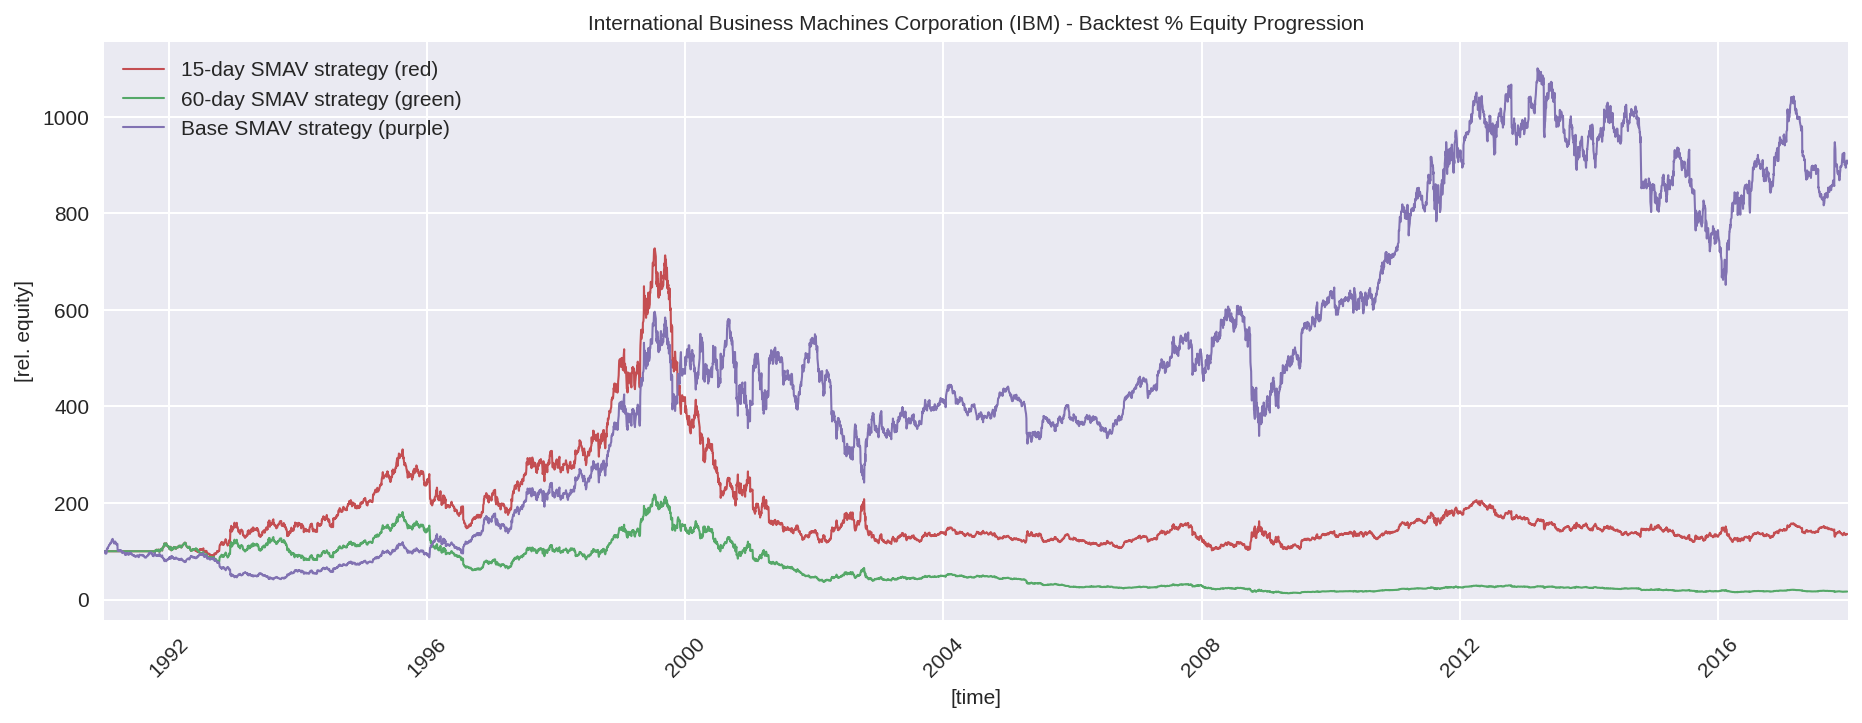

In [64]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot equity progression of the distinct trading strategies
ax.plot(backtest_sma_15_ibm_details['Rel. EQUITY'], color='C2',lw=1.0, label='15-day SMAV strategy (red)')
ax.plot(backtest_sma_60_ibm_details['Rel. EQUITY'], color='C1',lw=1.0, label='60-day SMAV strategy (green)')
ax.plot(backtest_sma_base_ibm_details['Rel. EQUITY'], color='C3',lw=1.0, label='Base SMAV strategy (purple)')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[rel. equity]', fontsize=10)

# set plot legend
plt.legend(loc="upper left", numpoints=1, fancybox=True)

# set plot title
plt.title('International Business Machines Corporation (IBM) - Backtest % Equity Progression', fontsize=10);